In [549]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

<img src="images/tuile.jpg" alt='tuile' style='margin-left:0;' />


# Modèlisation de la température des tuiles d'un toit

Mon appartement est sous les toits. Je ressens donc l'effet direct du soleil sur la température de mon appartement. Je peux aussi facilement mesurer la température des tuiles avec un [thermomètre IR](https://www.google.fr/search?&q=IR+260-8S+thermometer+voltcraft), en passant le bras à travers le velux. J'ai donc voulu savoir s'il est possible de prédire correctement la température des tuiles à partir des données météo et de l'irradiation solaire. 


Le premier problème est d'obtenir les **données météo** heure par heure, ainsi que la valeur de l'**irradiation solaire**.  

La question suivante est de correctement décrire **les échanges thermiques** entre les tuiles et le reste de l'univers ... les tuiles sont chauffées par le soleil, et refroidit par l'air ambiant (convection) et l'échange de rayonnement avec le ciel (corps gris/noir). Aussi, de façon négligeable par la conduction à travers la structure du toit. 

Une fois l'ensemble des contributions chiffrées, on effectue la **résolution numérique** du système, ici assez simple. Et, enfin, on peut **valider le modèle** en comparant les résultats avec les mesures effectuées. 

<img src="images/sch_model02.jpg" width="400px" alt='schema mod02' />

L'équilibre thermique des tuiles du toit est calculé en prennant en compte :
    - Le rayonnement solaire direct sur le toit (phi(t))
    - Le rayonnement propre des tuiles (corps noir)
    - Le rayonnement thermique du ciel (corps noir)
    - La convection avec l'air extérieur (forcée par le vent, ou bien naturelle)
    
En revanche, sont considérés comme négligeable : 
    - Le flux de chaleur à travers l'isolation du toit (~ 0.17 W/m2/K ).
    - L'inertie thermique des tuiles. 
    - La pluie, et l'humidité de l'air. 



In [613]:
coords_gps = (45.1973288, 5.7139923) # (latitude, longitude), degrée décimaux

# Période d'intérêt :
startday = pd.to_datetime('25/06/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday  = pd.to_datetime( '01/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')

# Obtention des données météo

Le site web [DarkSky.net](https://darksky.net/dev/docs) fourni une API gratuite pour avoir les historiques de données météo à une certaine position GPS. Il existe aussi une libraire python [darkskylib](https://github.com/lukaskubis/darkskylib) simplifiant les échanges avec l'API.  

Par dessus, j'ai un module perso (`weatherfeed`) avec les fonctions de téléchargement jour par jour et de construction d'un [DataFrame pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) unique.


In [614]:
import weatherfeed as wf

In [615]:
# téléchargement des données:
data = wf.buildmultidayDF(startday, lastday, coords_gps )

25, 26, 27, 28, 29, 30, 1, done


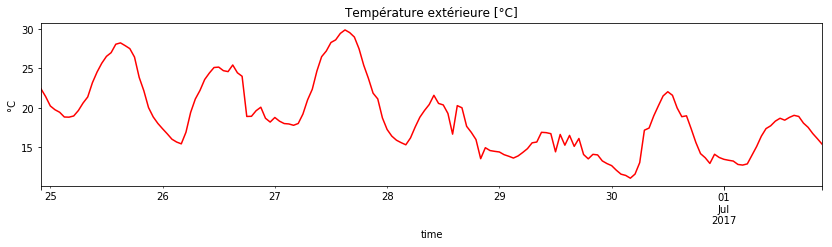

In [616]:
data['temperature'].plot(figsize=(14, 3), color='r' ); plt.ylabel('°C'); plt.title('Température extérieure [°C]');

Sont disponible aussi pleins d'autres mesures, et en particulier la _vitesse du vent_ et la _couverture nuageuse_.

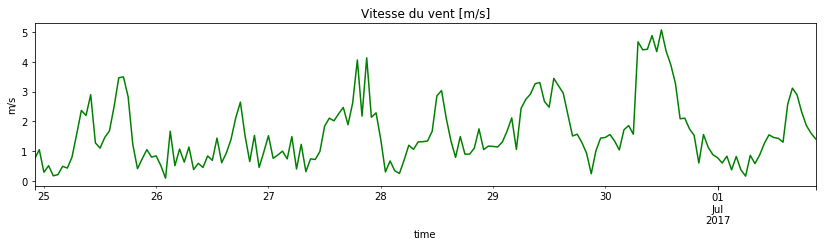

In [617]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s'); plt.title('Vitesse du vent [m/s]');

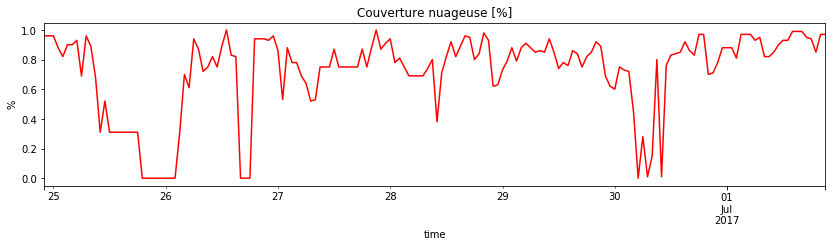

In [618]:
data['cloudCover'].plot(figsize=(14, 3), color='r' ); plt.ylabel('%'); plt.title('Couverture nuageuse [%]');

On aura besoin aussi du degrée d'humidité dans l'air:

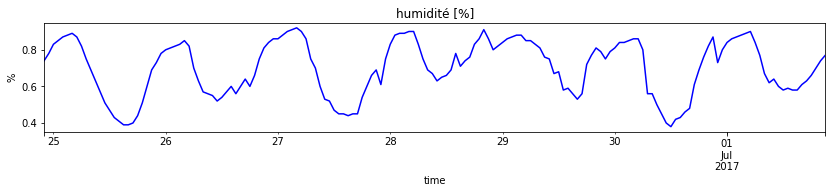

In [619]:
plt.figure()
data['humidity'].plot(figsize=(14, 2), color='b' ); plt.ylabel('%'); plt.title('humidité [%]');

Et il peut être intéressant aussi de voir l'effet de la pluie: 

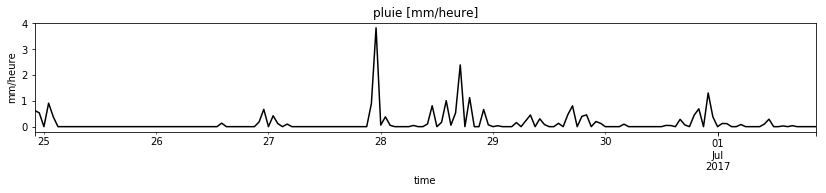

In [620]:
plt.figure()
data['precipIntensity'].plot(figsize=(14, 2), color='k' ); plt.ylabel('mm/heure'); plt.title('pluie [mm/heure]');

# Irradiation solaire

Le calcul de l'irradiation solaire est avant tout un problème géométrique avec l'angle de l'axe de rotation de la terre, la position de la terre sur son orbite et notre position sur le globe. Il existe une libraire python réalisant ce calcul: [pysolar.org](http://pysolar.org/). L'atténuation du flux solaire par l'épaisseur de la couche d'atmosphère traversée est aussi prise en compte. 

Un affinement possible du modèle prend en compte la hauteur de l'horizon. Ceci est surtout utile en région de montagne (horizon à ~ 15° le matin chez moi). Voir le notebook [ombres_montagnes](./ombres_montagnes.ipynb). 

De même, j'ai écris un module avec les fonctions utiles pour obtenir simplement un _Dataframe_ unique.


In [621]:
import sunradiation as sun

In [622]:
sundata = sun.buildmultidayDF( coords_gps, data.index  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


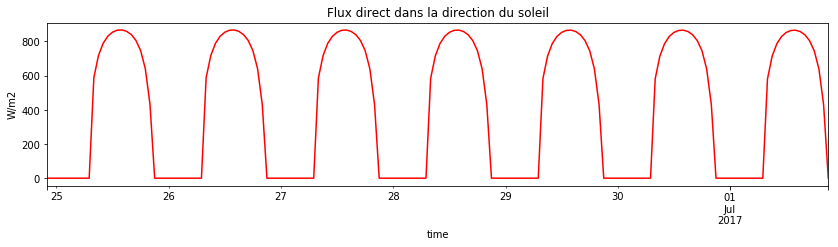

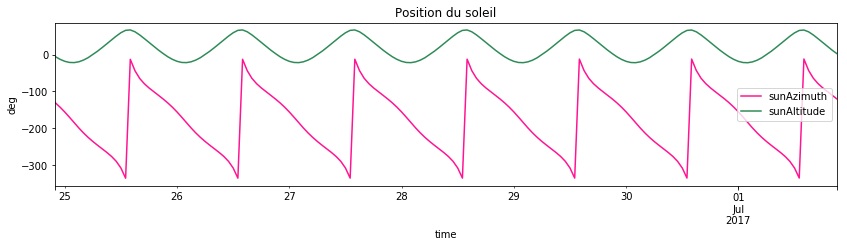

In [623]:
sundata['I0'].plot( figsize=(14, 3), style='r' );plt.ylabel('W/m2'); plt.title('Flux direct dans la direction du soleil');

plt.figure();
sundata['sunAzimuth'].plot( figsize=(14, 3), style='deeppink' );plt.ylabel('deg');
sundata['sunAltitude'].plot( figsize=(14, 3), style='seagreen' );
plt.title('Position du soleil'); plt.legend();


** Effet de la couverture nuageuse ? ** L'aspect difficile dans l'estimation de la radiation solaire arrivant au sol est de correctement prendre en compte l'effet des nuages, et de la radiation diffuse. Il ne semble pas avoir de modèle standard, mais différents modèles empiriques dépendant du type de nuages et du climat local...  

La formule la plus simple trouvée et qui me semble cohérente est :  $ \Phi =  I0 \, (1 - 0.75 \, C^{3.4}) $, $C$ étant la couverture nuageuse, entre 0 et 1. C'est à dire que même par un ciel entièrement nuageux il y a 25% du rayonement qui arrive au sol, et la relation est non linéaire pour les couvertures nuageuse intermédiaires.

    Solar and terrestrial radiation dependent on the amount and type of cloud. Kasten, F., & Czeplak, G. (1980). Solar energy, 24(2), 177-189.
    
L'effet et la prise en compte de la _radiation diffuse_ n'est pas encore claire pour moi, mais en comparant avec les valeurs de radiation données par Météoblue.com, j'obtiens les mêmes ordres de grandeurs.

In [624]:
cloud_attenuation = lambda c: 1 - 0.75* c**(3.4)

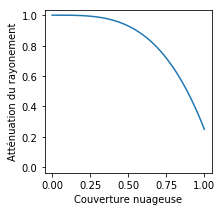

In [626]:
# graph
c = np.linspace(0, 1, 50); plt.figure(figsize=(3, 3));
plt.plot( c, cloud_attenuation(c)); plt.axis('equal'); plt.ylim([0, 1]); plt.xlabel('Couverture nuageuse');
plt.ylabel('Atténuation du rayonement');

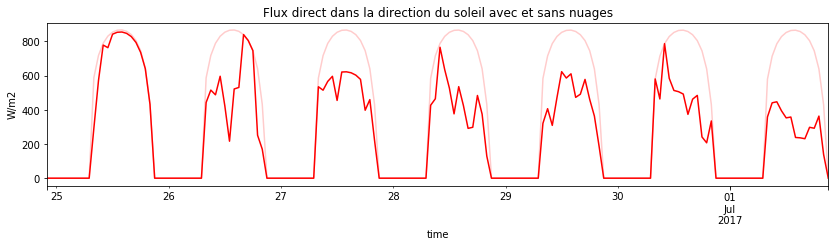

In [627]:
sundata['I_sol']  = sundata['I0']*cloud_attenuation( data['cloudCover']  )

# graph
sundata['I0'].plot( figsize=(14, 3), style='r', alpha=0.2 );plt.ylabel('W/m2'); 
sundata['I_sol'].plot( figsize=(14, 3), style='r' );plt.ylabel('W/m2');
plt.title('Flux direct dans la direction du soleil avec et sans nuages');

### Projection sur une surface inclinée
I0 est le flux dans la direction des rayons du soleil. Il faut donc projeter ce flux sur la surface receptrice. Ceci consiste en un calcul d'angle et de trigonométrie :


<img src="images/sch_angleprojection.jpg" width="400px" alt='schema mod02' />

On note $\Gamma$ l'angle entre le rayon du soleil $\vec r$ et la normal à la surface receptrice $\vec n$. Ces deux vecteurs sont unitaires. On obtient $cos\,\Gamma$ avec le produit scalaire de ces deux vecteurs :
$$
cos\,\Gamma = \vec r \bullet \vec n =
\begin{bmatrix} sin\, \varphi_S \,\, cos\, \theta_S  \\ cos\, \varphi_S \,\, cos\, \theta_S  \\ sin\, \theta_S \end{bmatrix} \bullet \begin{bmatrix} sin\, \varphi \,\, sin\, \theta  \\ cos\, \varphi \,\, sin\, \theta  \\ cos\, \theta \end{bmatrix} 
$$

qui se simplifie :
$$
cos\,\Gamma = cos( \varphi - \varphi_S )\, . \,sin\, \theta \,.\, cos \, \theta_S + cos\,\theta \,.\, sin \, \theta_S
$$


Une surface d'aire $A$ vue sous l'angle $\Gamma$ a une surface projetée $A . cos\, \Gamma$. Le flux reçu par la surface est donc $I. cos\, \Gamma$.

In [628]:
rad = lambda x: x*np.pi/180

def get_cosGamma(sundata_row, theta, phi):
    theta, phi = rad(theta), rad(phi)
    theta_S = rad( sundata_row['sunAltitude']  )
    phi_S = rad( sundata_row['sunAzimuth']  )
    
    cosGamma = np.cos( phi - phi_S )*np.sin( theta )*np.cos( theta_S ) + np.cos( theta )*np.sin( theta_S )
    if  cosGamma<0 :  cosGamma = 0
    return cosGamma

L'angle du toit de mon appartement est d'environ 37° et l'orientation est de 50° par rapport au sud (50°+180° pour l'autre pan).

In [629]:
theta = 37   # deg
phi_bastille = 50  # deg
phi_vercors = 50+180  # deg

data['flux_bastille'] = sundata['I_sol'] * sundata.apply( get_cosGamma, axis=1, args=(theta, phi_bastille) )
data['flux_vercors'] =  sundata['I_sol'] * sundata.apply( get_cosGamma, axis=1, args=(theta, phi_vercors) )

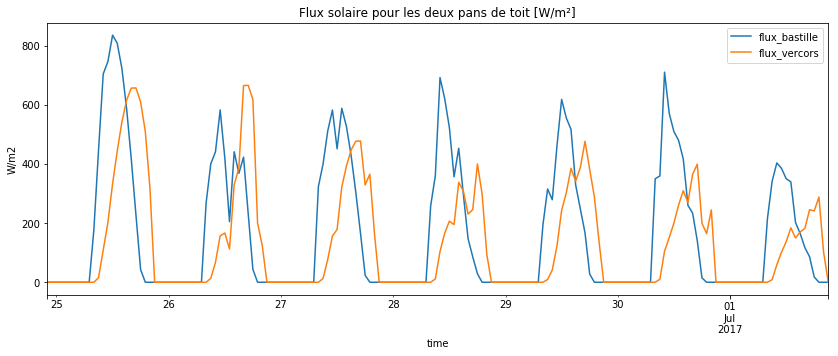

In [630]:
data[['flux_bastille', 'flux_vercors']].plot(figsize=(14, 5) )
plt.ylabel('W/m2');  plt.title('Flux solaire pour les deux pans de toit [W/m²]');

# Refroidissement par convection avec l'air ambiant

In [ ]:
""" Fonction du coefficient d'échange pour la convection thermique
"""
def coef_echange( vitesse_vent ):
    # vitesse_vent: m/s
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Prandl
    
    L = 4 # m, taille caractéristique, toit ou tuile ?
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 3e5:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
    
    return h

In [ ]:
v_span = np.linspace( 0, 3, 100 )
h_span = [ coef_echange( v ) for v in v_span ]

plt.plot( v_span, h_span ); plt.xlabel('vitesse vent (m/s)');plt.ylabel("coeff. d'échange (W/m²/K)");

# Echange par radiation

En plus de la radiation direct du soleil, il faut prendre en compte les échanges thermiques par émission du corps noir, qui peuvent être important. 

L'émission d'un corps à une température $T$ est donné par la loi de Stefan-Boltzmann :
$$
    P = \sigma \, \epsilon  \, \bar T ^4
$$

- $P$ est la puissance rayonnée dans le demi-espace, en W/m2
- $\sigma$ est la constante de Stefan-Boltzmann, W/m2/K4
- $\epsilon$ est l'émissivité de la surface
- $\bar T$ est la température de la surface, en Kelvin, c.a.d. $\bar T = T_{Celsius} + 273.15$

L'émission thermique des tuiles est en équilibre avec celle du ciel (l'atmosphère). En effet, sans cela la température d'équilibre prédite la nuit serait de -273°C ...

Le ciel à une certaine température et rayonne de la chaleur, en plus du rayonement directe du soleil. Cette température est généralement inférieure à la température ambiante de l'air en surface. Ceci explique par exemple la rosée et le givre par temps claire. 


In [ ]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [ ]:
albedo_tuile = 0.36   # Coefficient de reflexion des tuiles
emissivite_tuile = 0.92

In [ ]:
sigmaSB * emissivite_tuile * ( 0 + 273 )**4

In [ ]:
""" Rayonement thermique nocturne du ciel
    ou autrement dit la température du ciel la nuit,
    pouvant être bien inférieur à la température ambiante
"""

def Goforth_skyrad( cloudCover, Tair_deg, RH ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = Tair_deg + 273
    RH = RH*100

    Pthermal = ( 1 + K*cloudCover**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal

# Calcul de l'équilibre (statique)

Comme l'effet de l'inertie themique des tuiles est negligé, l'équation est le bilan des flux de chaleur :

$$
h(t)\,( T_{air}  - T  ) + (1-\alpha)\, \Phi(t) - \sigma_B \, \epsilon \, T^4 + P_{ciel}(t) = 0
$$

La resolution numérique est une recherche de zéro d'une fonction scalaire (de $T$). La méthode de Brent fonctionne très bien ([doc scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.brentq.html)). Elle est une version améliorée de la méthode de dichotomie et permet donc de spécifier un intervalle de recherche, excluant d'emblée les valeurs non physique.

In [ ]:
from scipy.optimize import brentq

In [ ]:
def model02_apply( datarow, flux_name=None, disp=False  ):
    
    
    # Flux directe soleil :
    flux_soleil = datarow[ flux_name ]
    rayonement_soleil = (1 - albedo_tuile) * flux_soleil
    
    # Convection :
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )   
    
    convection = lambda T:  h * ( T_air - T )
    
    # Rayonement 
    rayonement_toit = lambda T: -sigmaSB * emissivite_tuile * ( T + 273 )**4
    
    rayonement_ciel = Goforth_skyrad( datarow['cloudCover'], T_air, datarow['humidity']  )
    
    # Somme:
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    # Resolution numérique du zéro:
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    # sauvegarde des valeurs
    results = {}
    results['T_eq'] = T_eq
    results['convection'] =  convection(T_eq)
    results['flux_soleil'] =  rayonement_soleil
    results['rayonement_ciel'] =  rayonement_ciel
    results['rayonement_toit'] =  rayonement_toit(T_eq)
    
    return pd.Series( results )

In [580]:
results_bastille = data.apply(model02_apply, axis=1, flux_name='flux_bastille')
results_vercors = data.apply(model02_apply, axis=1, flux_name='flux_vercors')

KeyError: ('flux_bastille', 'occurred at index 2017-06-24 22:00:00')

In [ ]:
# note: https://stackoverflow.com/questions/37233574/creating-pandas-dataframe-where-each-header-column-will-have-two-sub-columns

In [ ]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

In [ ]:
results_bastille.drop('T_eq', axis=1).plot( figsize=(14, 5) ) ;
plt.ylabel('W/m2');  plt.title('Détail des flux de chaleur [W/m²]');

In [ ]:
# Zoom
zoom_start = pd.to_datetime( '28/06/2017' ) 
mask = (data.index > zoom_start)

In [ ]:
Ttuile.loc[mask].plot(figsize=(14, 6) ); plt.ylabel('T_tuile °C');

### Remarques
- Radiation diffuse ? equivalent à l'émission thermique du ciel  ?
- Prise en compte de la pluie ... ?

- La nuit Ttuile < T_air ... ? condensation ? effet sur la convection ? 

# Validation du modèle

La mesure est effectuée manuellement avec thermomètre infrarouge à travers les Velux, sur les deux pans du toit. 

In [ ]:
mesures = pd.read_csv('mesures/mesures_Ttuiles.csv', sep=';', index_col=2, parse_dates=True, decimal=',' )
mesures = mesures.drop(['Unnamed: 0', 'Unnamed: 1'], 1)

In [ ]:
# Zoom
zoom_start = pd.to_datetime( '27/06/2017' ) 
mask = (data.index > zoom_start)

In [ ]:
plt.figure( figsize=(14, 6) );  plt.ylabel('T °C');
plt.plot( mesures, ':o' )
plt.plot( Ttuile.loc[mask], '-' );

La valeur de la couverture nuageuse est determinante... et le temps orageux ... mais ça semble quand même pas trop mal

## Seconde serie de mesures

In [ ]:
startday = pd.to_datetime('10/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime( '11/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')

In [ ]:
data = wf.buildmultidayDF(startday, lastday, coords_gps )

In [ ]:
sundata = sun.buildmultidayDF( coords_gps, data.index, cloudCover = data['cloudCover']  )

data['flux_bastille'] = sun.projectDF( sigma, phi_C_bastille, sundata )
data['flux_vercors'] =  sun.projectDF( sigma, phi_C_vercors, sundata )

In [ ]:
results_bastille = data.apply(model02_apply, axis=1, flux_name='flux_bastille')
results_vercors = data.apply(model02_apply, axis=1, flux_name='flux_vercors')

Ttuile =  pd.DataFrame({ 'bastille':results_bastille['T_eq'], 'vercors':results_vercors['T_eq'] })

In [ ]:
dateparse = lambda d : pd.to_datetime( d, format='%d/%m/%Y %H:%M:%S' )

mesures = pd.read_csv('mesures/mesures2_Ttuiles.csv', sep=';', index_col=2, parse_dates=True, decimal=',', date_parser=dateparse )
mesures = mesures.drop(['Unnamed: 0', 'Unnamed: 1'], 1) 

In [ ]:
plt.figure( figsize=(14, 5) ); plt.ylabel('T °C');
plt.plot( mesures, ':o' )
plt.plot( Ttuile, '-' );